In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout, GlobalAveragePooling1D
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import mediapipe as mp
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import coremltools as ct

TensorFlow version 2.13.0 has not been tested with coremltools. You may run into unexpected errors. TensorFlow 2.12.0 is the most recent version that has been tested.
Torch version 2.4.1+cu118 has not been tested with coremltools. You may run into unexpected errors. Torch 2.4.0 is the most recent version that has been tested.
Fail to import BlobReader from libmilstoragepython. No module named 'coremltools.libmilstoragepython'
Failed to load _MLModelProxy: No module named 'coremltools.libcoremlpython'
Fail to import BlobWriter from libmilstoragepython. No module named 'coremltools.libmilstoragepython'


In [5]:
# MediaPipe hands model
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1, min_detection_confidence=0.5)
mp_drawing = mp.solutions.drawing_utils

In [7]:
def extract_hand_landmarks(image):
    """Extract hand landmarks from an image using MediaPipe."""
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = hands.process(image_rgb)
    
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmark_array = np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark])
            return landmark_array.flatten()
    return np.zeros(21 * 3)

In [13]:
def load_data(data_path):
    """Load data from a single dataset directory containing all gesture folders."""
    labels = []
    data = []
    
    print(f"Loading data from: {data_path}")
    
    # Get all gesture folders
    gesture_folders = [f for f in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, f))]
    print(f"Found {len(gesture_folders)} gesture categories")
    
    # Process each gesture folder
    for gesture in gesture_folders:
        gesture_path = os.path.join(data_path, gesture)
        print(f"Processing gesture: {gesture}")
        
        # Get all images for this gesture
        images = [f for f in os.listdir(gesture_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        for image_file in tqdm(images, desc=f"Processing {gesture}"):
            image_path = os.path.join(gesture_path, image_file)
            try:
                image = cv2.imread(image_path)
                if image is not None:
                    hand_landmarks = extract_hand_landmarks(image)
                    data.append(hand_landmarks)
                    labels.append(gesture.lower())  # Convert to lowercase for consistency
            except Exception as e:
                print(f"Error processing {image_path}: {str(e)}")
                continue
        
        print(f"Processed {len(images)} images for {gesture}")
    
    return np.array(data), np.array(labels)

In [17]:
# Load your ASL alphabet dataset (adjust path)
dataset_path = "./dataset/asl_alphabet_train/asl_alphabet_train/"

print("Starting data loading process...")
X, y = load_data(dataset_path)
print(f"Loaded {len(X)} total samples across {len(np.unique(y))} categories")

Starting data loading process...
Loading data from: ./dataset/asl_alphabet_train/asl_alphabet_train/
Found 40 gesture categories
Processing gesture: A


Processing A:   0%|                                                                           | 0/3000 [00:00<?, ?it/s]C:\Users\abhis\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Processing A: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [04:06<00:00, 12.17it/s]


Processed 3000 images for A
Processing gesture: B


Processing B: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:52<00:00, 12.92it/s]


Processed 3000 images for B
Processing gesture: C


Processing C: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:26<00:00, 14.53it/s]


Processed 3000 images for C
Processing gesture: call


Processing call: 100%|█████████████████████████████████████████████████████████████| 2265/2265 [05:51<00:00,  6.45it/s]


Processed 2265 images for call
Processing gesture: D


Processing D: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:30<00:00, 14.28it/s]


Processed 3000 images for D
Processing gesture: del


Processing del: 100%|██████████████████████████████████████████████████████████████| 3000/3000 [03:11<00:00, 15.64it/s]


Processed 3000 images for del
Processing gesture: dislike


Processing dislike: 100%|██████████████████████████████████████████████████████████| 2094/2094 [05:22<00:00,  6.49it/s]


Processed 2094 images for dislike
Processing gesture: E


Processing E: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:29<00:00, 14.31it/s]


Processed 3000 images for E
Processing gesture: F


Processing F: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:35<00:00, 13.93it/s]


Processed 3000 images for F
Processing gesture: fist


Processing fist: 100%|█████████████████████████████████████████████████████████████| 2590/2590 [06:41<00:00,  6.45it/s]


Processed 2590 images for fist
Processing gesture: G


Processing G: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:24<00:00, 14.68it/s]


Processed 3000 images for G
Processing gesture: grabbing


Processing grabbing: 100%|█████████████████████████████████████████████████████████| 4371/4371 [11:50<00:00,  6.15it/s]


Processed 4371 images for grabbing
Processing gesture: grip


Processing grip: 100%|█████████████████████████████████████████████████████████████| 2791/2791 [07:34<00:00,  6.15it/s]


Processed 2791 images for grip
Processing gesture: H


Processing H: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:36<00:00, 13.87it/s]


Processed 3000 images for H
Processing gesture: I


Processing I: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:35<00:00, 13.95it/s]


Processed 3000 images for I
Processing gesture: J


Processing J: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:46<00:00, 13.26it/s]


Processed 3000 images for J
Processing gesture: K


Processing K: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:33<00:00, 14.06it/s]


Processed 3000 images for K
Processing gesture: L


Processing L: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:29<00:00, 14.32it/s]


Processed 3000 images for L
Processing gesture: like


Processing like: 100%|█████████████████████████████████████████████████████████████| 2369/2369 [06:13<00:00,  6.34it/s]


Processed 2369 images for like
Processing gesture: M


Processing M: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:13<00:00, 15.53it/s]


Processed 3000 images for M
Processing gesture: N


Processing N: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:11<00:00, 15.64it/s]


Processed 3000 images for N
Processing gesture: nothing


Processing nothing: 100%|██████████████████████████████████████████████████████████| 3000/3000 [02:25<00:00, 20.67it/s]


Processed 3000 images for nothing
Processing gesture: O


Processing O: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:28<00:00, 14.41it/s]


Processed 3000 images for O
Processing gesture: ok


Processing ok: 100%|███████████████████████████████████████████████████████████████| 2444/2444 [06:36<00:00,  6.16it/s]


Processed 2444 images for ok
Processing gesture: P


Processing P: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:31<00:00, 14.20it/s]


Processed 3000 images for P
Processing gesture: palm


Processing palm: 100%|█████████████████████████████████████████████████████████████| 2438/2438 [06:23<00:00,  6.36it/s]


Processed 2438 images for palm
Processing gesture: Q


Processing Q: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:12<00:00, 15.57it/s]


Processed 3000 images for Q
Processing gesture: R


Processing R: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:45<00:00, 13.32it/s]


Processed 3000 images for R
Processing gesture: rock


Processing rock: 100%|█████████████████████████████████████████████████████████████| 2355/2355 [06:09<00:00,  6.38it/s]


Processed 2355 images for rock
Processing gesture: S


Processing S: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:37<00:00, 13.82it/s]


Processed 3000 images for S
Processing gesture: space


Processing space: 100%|████████████████████████████████████████████████████████████| 3000/3000 [03:14<00:00, 15.43it/s]


Processed 3000 images for space
Processing gesture: stop


Processing stop: 100%|█████████████████████████████████████████████████████████████| 2406/2406 [06:18<00:00,  6.36it/s]


Processed 2406 images for stop
Processing gesture: stop_inv


Processing stop_inv: 100%|█████████████████████████████████████████████████████████| 2114/2114 [06:06<00:00,  5.77it/s]


Processed 2114 images for stop_inv
Processing gesture: T


Processing T: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:44<00:00, 13.38it/s]


Processed 3000 images for T
Processing gesture: U


Processing U: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:44<00:00, 13.39it/s]


Processed 3000 images for U
Processing gesture: V


Processing V: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:48<00:00, 13.10it/s]


Processed 3000 images for V
Processing gesture: W


Processing W: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:41<00:00, 13.52it/s]


Processed 3000 images for W
Processing gesture: X


Processing X: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:37<00:00, 13.79it/s]


Processed 3000 images for X
Processing gesture: Y


Processing Y: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:47<00:00, 13.21it/s]


Processed 3000 images for Y
Processing gesture: Z


Processing Z: 100%|████████████████████████████████████████████████████████████████| 3000/3000 [03:38<00:00, 13.73it/s]


Processed 3000 images for Z
Loaded 115237 total samples across 40 categories


In [19]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Create label mapping
label_map = {label: idx for idx, label in enumerate(label_encoder.classes_)}
reverse_label_map = {idx: label for label, idx in label_map.items()}

In [21]:
# Save label mappings for later use
import json
with open('label_mappings.json', 'w') as f:
    json.dump({
        'label_map': label_map,
        'reverse_label_map': {str(k): v for k, v in reverse_label_map.items()}  # Convert keys to strings for JSON
    }, f, indent=4)

In [23]:
# Normalize the data
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)

In [25]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_categorical, test_size=0.2, random_state=42)

In [27]:
# Reshape data for Conv1D
X_train = X_train.reshape(X_train.shape[0], 21, 3)
X_test = X_test.reshape(X_test.shape[0], 21, 3)

In [29]:
# 7. Verify shapes
print("\nFinal shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

# 8. Verify data ranges
print("\nData ranges:")
print(f"X_train min: {X_train.min()}, max: {X_train.max()}")
print(f"Sample label distribution: {y_encoded[:10]}")


Final shapes:
X_train: (92189, 21, 3)
X_test: (23048, 21, 3)
y_train: (92189, 40)
y_test: (23048, 40)

Data ranges:
X_train min: 0.0, max: 1.0
Sample label distribution: [0 0 0 0 0 0 0 0 0 0]


In [31]:
# Define the model
num_classes = len(label_encoder.classes_)
model = Sequential([
    Conv1D(64, 3, activation='relu', input_shape=(21, 3), padding='same'),
    MaxPooling1D(2),
    
    Conv1D(128, 3, activation='relu', padding='same'),
    MaxPooling1D(2),
    
    Conv1D(256, 3, activation='relu', padding='same'),
    GlobalAveragePooling1D(),
    
    Dense(128, activation='relu'),
    Dropout(0.5),
    
    Dense(64, activation='relu'),
    Dropout(0.3),
    
    Dense(num_classes, activation='softmax')
])

In [33]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=150, validation_split=0.2, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/150
2305/2305 [==============================] - 26s 10ms/step - loss: 2.6143 - accuracy: 0.2270 - val_loss: 1.4860 - val_accuracy: 0.5920
Epoch 2/150
2305/2305 [==============================] - 24s 11ms/step - loss: 1.5009 - accuracy: 0.5524 - val_loss: 1.1307 - val_accuracy: 0.6919
Epoch 3/150
2305/2305 [==============================] - 24s 10ms/step - loss: 1.2501 - accuracy: 0.6441 - val_loss: 1.0411 - val_accuracy: 0.7243
Epoch 4/150
2305/2305 [==============================] - 24s 11ms/step - loss: 1.1562 - accuracy: 0.6805 - val_loss: 1.0261 - val_accuracy: 0.7181
Epoch 5/150
2305/2305 [==============================] - 25s 11ms/step - loss: 1.0987 - accuracy: 0.6982 - val_loss: 0.9721 - val_accuracy: 0.7418
Epoch 6/150
2305/2305 [==============================] - 24s 10ms/step - loss: 1.0647 - accuracy: 0.7110 - val_loss: 0.9677 - val_accuracy: 0.7395
Epoch 7/150
2305/2305 [==============================] - 25s 11ms/step - loss: 1.0404 - accuracy: 0.7186 - val_loss: 0

In [35]:
# Print model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 21, 64)            640       
                                                                 
 max_pooling1d (MaxPooling1  (None, 10, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 10, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 5, 128)            0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 256)            98560     
                                                                 
 global_average_pooling1d (  (None, 256)               0

In [37]:
# Step 10: Save the model for edge deployment
model.save('asl_recognition_model811.h5')

C:\Users\abhis\anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [60]:
import joblib
joblib.dump(scaler, 'scaler.save')

['scaler.save']

721/721 [==============================] - 3s 4ms/step


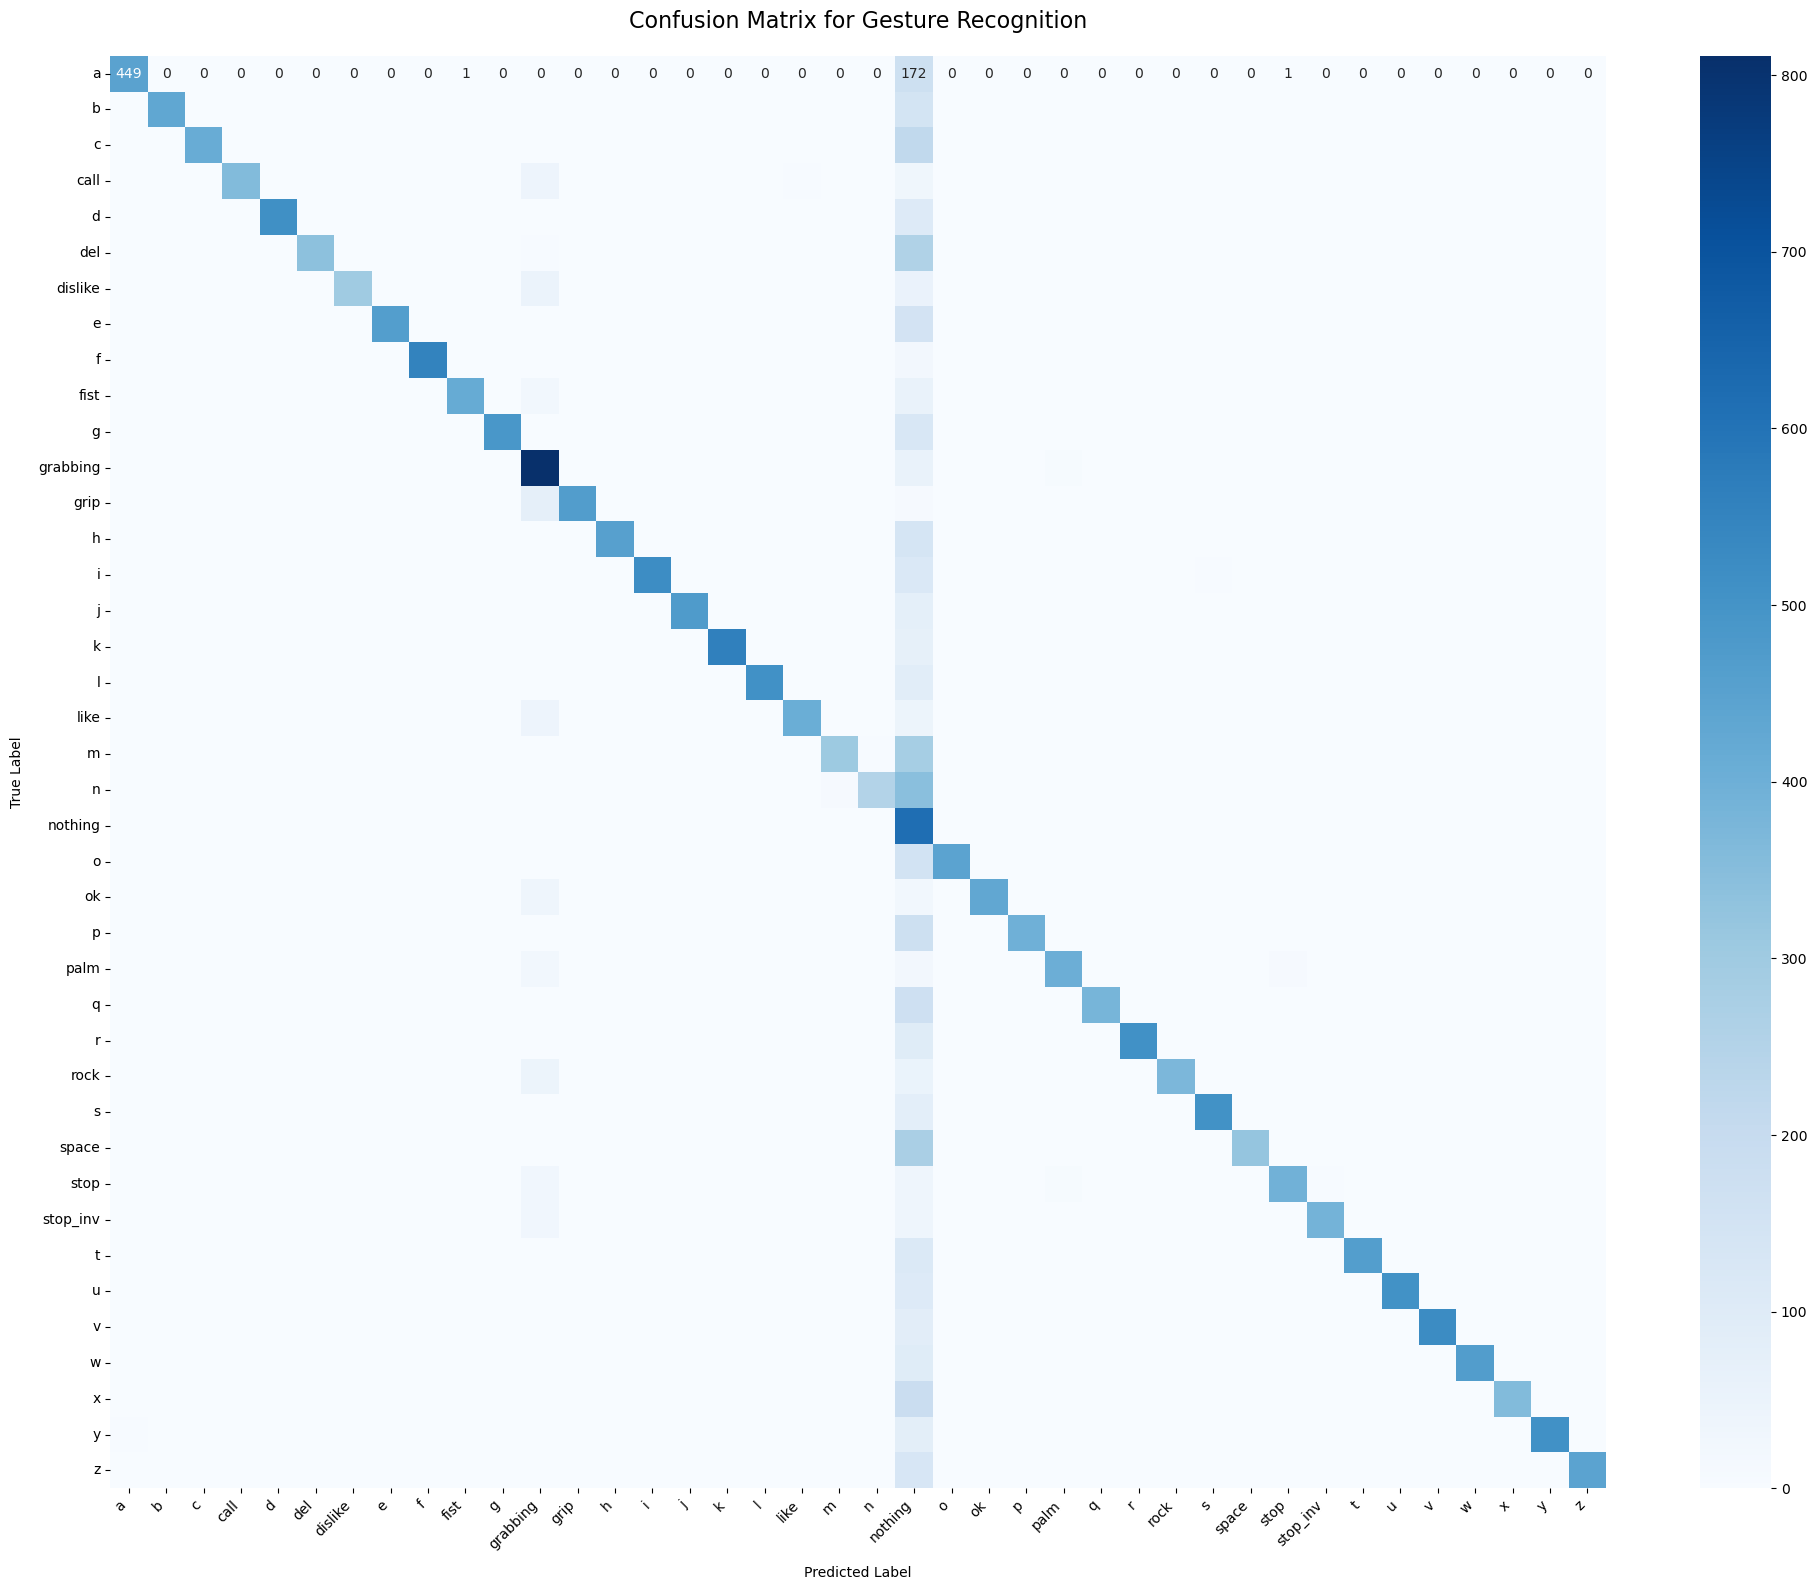

NameError: name 'history' is not defined

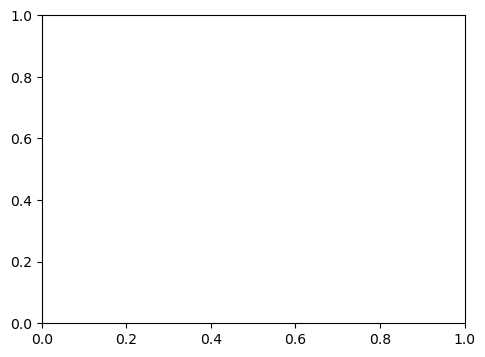

In [39]:
# Generate and plot confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

plt.figure(figsize=(20, 16))
cm = confusion_matrix(y_true_classes, y_pred_classes)
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)

plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title('Confusion Matrix for Gesture Recognition', pad=20, size=16)
plt.xlabel('Predicted Label', labelpad=10)
plt.ylabel('True Label', labelpad=10)
plt.tight_layout()
plt.show()


# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, 
                          target_names=label_encoder.classes_,
                          zero_division=0))


Classification Report:
              precision    recall  f1-score   support

           a       0.98      0.72      0.83       623
           b       1.00      0.75      0.85       578
           c       0.99      0.65      0.79       631
        call       0.98      0.81      0.89       445
           d       1.00      0.82      0.90       622
         del       0.99      0.56      0.71       601
     dislike       0.98      0.73      0.84       407
           e       1.00      0.75      0.86       619
           f       1.00      0.96      0.98       579
        fist       0.96      0.83      0.89       505
           g       1.00      0.79      0.88       621
    grabbing       0.66      0.91      0.77       889
        grip       0.99      0.84      0.91       556
           h       1.00      0.76      0.86       603
           i       0.99      0.80      0.89       650
           j       1.00      0.86      0.92       552
           k       0.99      0.89      0.94       634
   

In [46]:
# Real-time prediction function
def real_time_prediction():
    cap = cv2.VideoCapture(0)
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
            
        frame = cv2.flip(frame, 1)
        hand_landmarks = extract_hand_landmarks(frame)
        
        if np.any(hand_landmarks):
            # Prepare input data
            input_data = scaler.transform(hand_landmarks.reshape(1, -1))
            input_data = input_data.reshape(1, 21, 3)
            
            # Make prediction
            prediction = model.predict(input_data, verbose=0)
            predicted_class = np.argmax(prediction)
            confidence = np.max(prediction)
            
            # Get predicted label
            predicted_label = reverse_label_map[predicted_class]
            
            # Display prediction
            text = f"{predicted_label.upper()} ({confidence:.2f})"
            cv2.putText(frame, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
            
        cv2.imshow('Gesture Recognition', frame)
        
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    cap.release()
    cv2.destroyAllWindows()

In [57]:
try:
    real_time_prediction()
except:
    print("Something else went wrong")
    cv2.destroyAllWindows()
finally:
    cv2.destroyAllWindows()

C:\Users\abhis\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\Users\abhis\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\Users\abhis\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
C:\Users\abhis\anaconda3\Lib\site-packages\google

In [49]:
cv2.destroyAllWindows()

<h3>Converting models: </h3>

In [12]:
from tensorflow.keras.models import load_model
import coremltools as ct

In [14]:
model = load_model('asl_recognition_model811.h5')

In [16]:
# Convert the model to Core ML format, specifying a fixed input shape
coreml_model = ct.convert(model, inputs=[ct.TensorType(shape=(1, 21, 3))])

# Save the model as an .mlmodel file
coreml_model.save('asl_recognition_model811.mlmodel')

Running MIL backend_mlprogram pipeline: 100%|████████████████████████████████████| 12/12 [00:00<00:00, 435.58 passes/s]


RuntimeError: BlobWriter not loaded

In [9]:
# Initialize the converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Perform the conversion
tflite_model = converter.convert()

# Save the converted model to a .tflite file
with open('asl_recognition_model811.tflite', 'wb') as f:
    f.write(tflite_model)

# Enable optimization (such as quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]